In [1]:
from model.fasterrcnn import *
from model.advattack import *
from data_utils.utils import *
from data_utils.arraytools import *

import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

test_img_list, test_bboxes = wider_read(limit_images=None, train=False)

test_dataset = WiderDataset(test_img_list, test_bboxes)

test_loader = DataLoader(test_dataset,
                         batch_size=1,
                         shuffle=True,
                         num_workers=0,
                         collate_fn=collate_fn
                         )

In [3]:
model = load_Faster_RCNN(backbone='resnet18')

# model.to(device)

checkpoint = torch.load('./saved_models/fasterrcnn_resnet18_2021-03-27_fresh.pth')
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [4]:
checkpoint['epoch']

4

In [4]:
start = time.time()

prediction_info = []
target_info = []
model.eval()

for images, targets in test_loader:
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    with torch.no_grad():
        predictions = model(images)
    
    predictions = [{k: v.to('cpu').detach() for k, v in t.items()} for t in predictions]
    targets = [{k: v.to('cpu').detach() for k, v in t.items()} for t in targets]
    prediction_info.append(predictions)
    target_info.append(targets)
    images = list(image.detach() for image in images)
    images.clear()
#     targets.clear()
    torch.cuda.empty_cache()

end = time.time()
print(f"Time elapsed in Predicting: {(end - start)/60:.2f} minutes")
prediction_info = list(itertools.chain(*prediction_info))
target_info = list(itertools.chain(*target_info))

Time elapsed in Predicting: 14.39 minutes


In [24]:
model.to('cpu')
torch.cuda.empty_cache()

In [5]:
results = {}
for i in range(4,8):
    r_temp = evaluation(prediction_info, target_info, iou_thresh=i/10, interpolation_method='EveryPoint')
    results[i/10] = r_temp
    

Processing :   1%|          | 21/3135 [00:00<00:22, 139.02it/s]

3135


Processing :   1%|          | 21/3135 [00:00<00:22, 139.78it/s]

3135


Processing :   1%|          | 21/3135 [00:00<00:21, 146.58it/s]

3135


Processing :   1%|          | 21/3135 [00:00<00:21, 144.92it/s]

3135


Processing : 100%|██████████| 3135/3135 [00:14<00:00, 212.73it/s]


For the Threshold 0.4


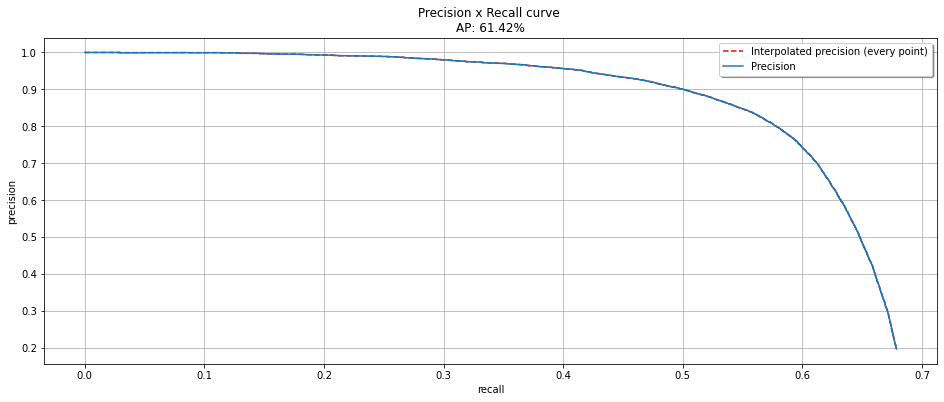


For the Threshold 0.5


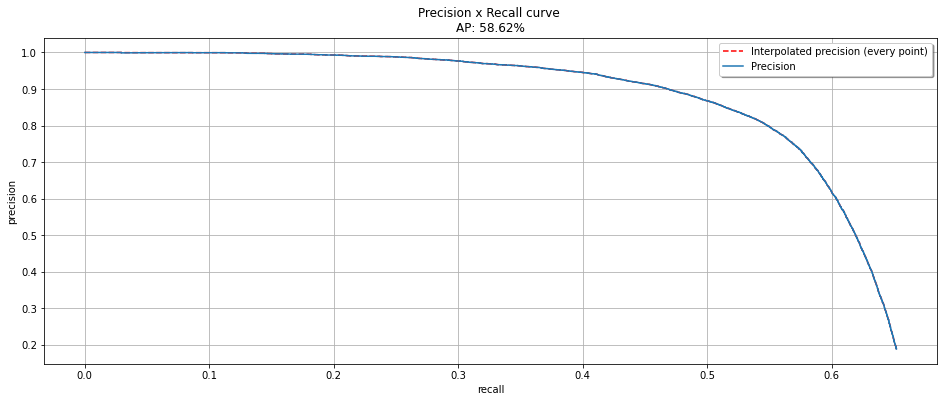


For the Threshold 0.6


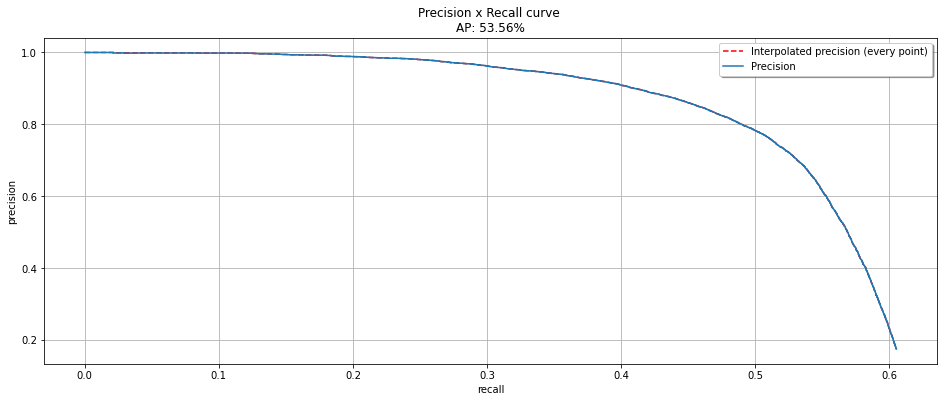


For the Threshold 0.7


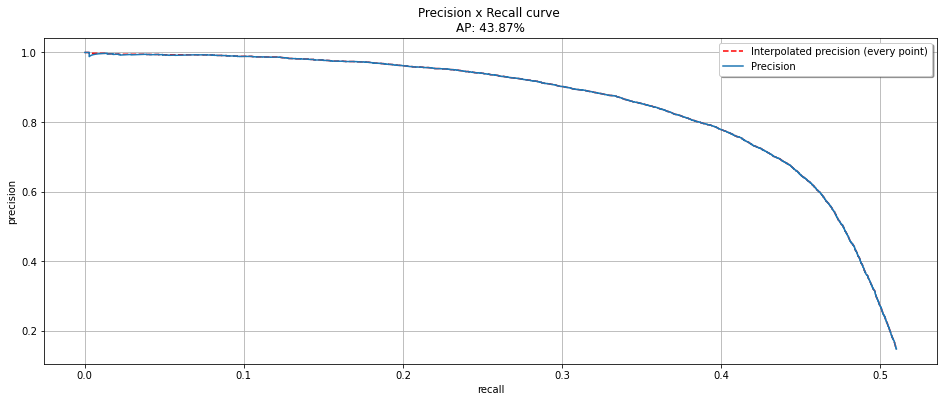

In [6]:
for thres, result in results.items():
    print(f'For the Threshold {thres}')
    PlotPrecisionRecallCurve(result)
    print()